# Model Deployement Demo
### **Note:**

Due to the computational heaviness of the Random Forest model and the large size of the dataset, performing grid search to tune the model can be extremely resource-intensive and time-consuming. Therefore, in this section, I will create and optimize the model using an 1 milion size sample of the data. This sample of the dataset was created during the earlier phases of the project. By focusing on a smaller, yet substantial, subset of the data, we can achieve efficient model training and tuning while ensuring the model is adequately representative of the overall dataset.


             Carrier_Name  Month_Day   Week_Day Flight_Date  Airline_DOT_ID  \
0  Southwest Airlines Co.         12   Thursday  2023-10-12           19393   
1  Southwest Airlines Co.         15     Friday  2023-12-15           19393   
2  Southwest Airlines Co.         21    Tuesday  2023-11-21           19393   
3   United Air Lines Inc.          9     Sunday  2023-07-09           19977   
4  American Airlines Inc.         19     Monday  2024-02-19           19805   
5   United Air Lines Inc.         31  Wednesday  2024-01-31           19977   
6        Spirit Air Lines         22     Friday  2023-09-22           20416   
7  American Airlines Inc.         19   Thursday  2023-10-19           19805   
8   SkyWest Airlines Inc.          9     Friday  2024-02-09           20304   
9  Southwest Airlines Co.         15   Saturday  2023-07-15           19393   

  Tail_Number  Flight_Number  Origin_Airport_ID  Origin_City_Market_ID  \
0      N793SA           1138              11292         

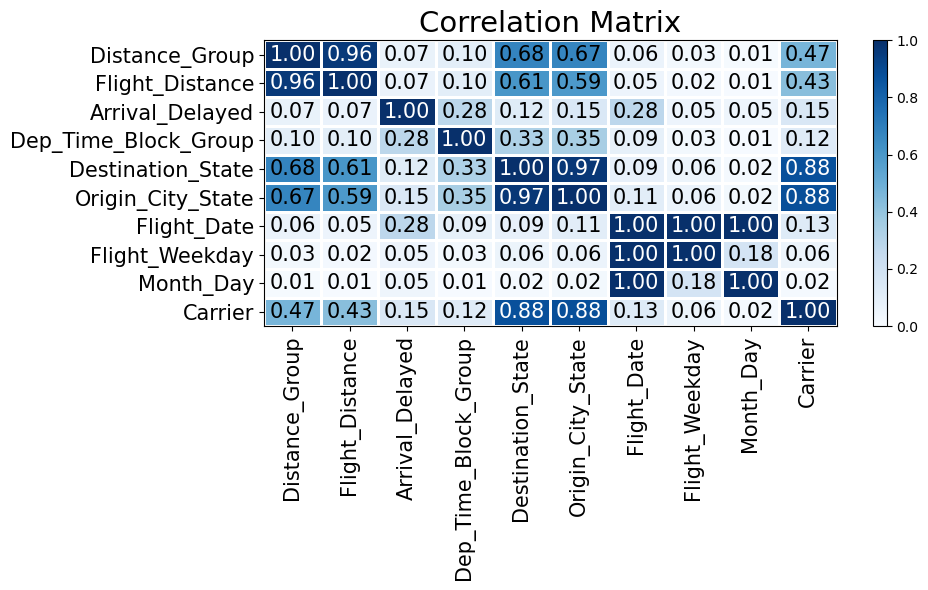

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import phik
from phik.report import plot_correlation_matrix
import pickle

# Import the dataset
dataset = pd.read_csv("sample.csv")

# Inspect the dataset
print(dataset.head(10))

# Check for duplicates
print(f"Number of duplicates: {dataset.duplicated().sum()}")

# Check for missing values per column
print("Missing values per column:\n", dataset.isnull().sum())

# Correct dtypes if needed
dataset['Arr_Delay_At_Least_15_Minutes'] = dataset['Arr_Delay_At_Least_15_Minutes'].astype(int)

# Rename columns for consistency
dataset = dataset.rename(columns={
    'Carrier_Name': 'Carrier',
    'Week_Day': 'Flight_Weekday',
    'Destination_City_State': 'Destination_State',
    'Distance_Miles': 'Flight_Distance',
    'Arr_Delay_At_Least_15_Minutes': 'Arrival_Delayed'
})

# Drop unnecessary variables
variables_to_drop = ['Airline_DOT_ID', 'Flight_Number', 'Number_of_Flights', 'Tail_Number', 'Origin_Airport_ID',
                     'Origin_IATA_Code', 'Origin_City_Market_ID', 'Destination_Airport_ID', 'Destination_IATA_Code',
                     'Destination_City_Market_ID', 'Scheduled_Departure_Time', 'Scheduled_Arrival_Time',
                     'Scheduled_Gate_to_Gate_Time', 'Dep_Delay_At_Least_15_Minutes', 'Flight_Cancelled',
                     'Arr_Time_Block_Group', 'Flight_Diverted']
dataset = dataset.drop(variables_to_drop, axis=1)
print("Remaining columns:", dataset.columns)

# Calculate the correlation matrix using Phik
corr_matrix = dataset.phik_matrix()
plot_correlation_matrix(corr_matrix.values,
                        x_labels=corr_matrix.columns,
                        y_labels=corr_matrix.index,
                        vmin=0,
                        vmax=1,
                        color_map="Blues",
                        title="Correlation Matrix",
                        fontsize_factor=1.5,
                        figsize=(10, 6))

# Select features based on correlation with 'Arrival_Delayed'
target_variable = 'Arrival_Delayed'
relevant_features = corr_matrix[target_variable][(corr_matrix[target_variable] >= 0.15) | (corr_matrix[target_variable] <= -0.15)].index.tolist()
print("Selected Features based on correlation with 'Arrival_Delayed':", relevant_features)


In [9]:
# Feature engineering: Convert 'Flight_Date' to datetime and extract additional features
dataset['Flight_Date'] = pd.to_datetime(dataset['Flight_Date'])
dataset['Year'] = dataset['Flight_Date'].dt.year
dataset['Month'] = dataset['Flight_Date'].dt.month
dataset['Day'] = dataset['Flight_Date'].dt.day

# Define features and target
selected_features = ['Year', 'Month', 'Day', 'Dep_Time_Block_Group', 'Carrier']
X = dataset[selected_features]
y = dataset['Arrival_Delayed']

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Year', 'Month', 'Day']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Dep_Time_Block_Group', 'Carrier'])
    ])

# Apply the preprocessing pipeline to X
X_preprocessed = preprocessor.fit_transform(X)
# Save the preprocessor
with open('preprocessor.pkl', 'wb') as file:
    pickle.dump(preprocessor, file)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.1, random_state=42)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


X_train shape: (900000, 24), X_test shape: (100000, 24)
y_train shape: (900000,), y_test shape: (100000,)


In [10]:

# Function to evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    return accuracy, precision, recall, f1, roc_auc

# Initialize and train the models
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
random_forest_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
xgb_model = XGBClassifier(n_estimators=50, use_label_encoder=False, eval_metric='logloss', n_jobs=-1, random_state=42)

models = [logistic_model, random_forest_model, xgb_model]
model_names = ["Logistic Regression", "Random Forest", "XGBoost"]

# Evaluate initial models and calculate average metrics
metrics_dict = {"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-score": [], "ROC-AUC": []}
for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    metrics = evaluate_model(model, X_test, y_test)
    metrics_dict["Model"].append(name)
    metrics_dict["Accuracy"].append(metrics[0])
    metrics_dict["Precision"].append(metrics[1])
    metrics_dict["Recall"].append(metrics[2])
    metrics_dict["F1-score"].append(metrics[3])
    metrics_dict["ROC-AUC"].append(metrics[4])
    print(f"{name}: Accuracy: {metrics[0]:.4f}, Precision: {metrics[1]:.4f}, Recall: {metrics[2]:.4f}, F1-score: {metrics[3]:.4f}, ROC-AUC: {metrics[4]:.4f}")

# Calculate average metrics for initial models
average_metrics = {key: np.mean(value) for key, value in metrics_dict.items() if key != "Model"}
print("Average Metrics for Initial Models:")
print(average_metrics)

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=4, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# Evaluate the best Random Forest model on the test set
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])

optimized_rf_metrics = {
    "Model": "Optimized Random Forest",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "ROC-AUC": roc_auc
}

print("Optimized Random Forest Metrics:")
print(optimized_rf_metrics)

# Compare average metrics of initial models with optimized Random Forest
print("Comparison:")
print("Average Metrics for Initial Models:", average_metrics)
print("Optimized Random Forest Metrics:", optimized_rf_metrics)
# save the best model for deployment
with open('best_rf_model.pkl', 'wb') as file:
    pickle.dump(best_rf, file)

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Logistic Regression: Accuracy: 0.6077, Precision: 0.6005, Recall: 0.6373, F1-score: 0.6184, ROC-AUC: 0.6078
Random Forest: Accuracy: 0.6470, Precision: 0.6494, Recall: 0.6348, F1-score: 0.6420, ROC-AUC: 0.6470
XGBoost: Accuracy: 0.6436, Precision: 0.6472, Recall: 0.6272, F1-score: 0.6370, ROC-AUC: 0.6436
Average Metrics for Initial Models:
{'Accuracy': 0.6327833333333334, 'Precision': 0.6323665576689423, 'Recall': 0.6330953526926573, 'F1-score': 0.6324682239717002, 'ROC-AUC': 0.6327841797238086}


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
32 fits failed out of a total of 64.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/_

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
Best CV Score: 0.6479177777777778
Optimized Random Forest Metrics:
{'Model': 'Optimized Random Forest', 'Accuracy': 0.6491, 'Precision': 0.6514039762246362, 'Recall': 0.6373736563452591, 'F1-score': 0.6443124455166541, 'ROC-AUC': 0.7030920637563245}
Comparison:
Average Metrics for Initial Models: {'Accuracy': 0.6327833333333334, 'Precision': 0.6323665576689423, 'Recall': 0.6330953526926573, 'F1-score': 0.6324682239717002, 'ROC-AUC': 0.6327841797238086}
Optimized Random Forest Metrics: {'Model': 'Optimized Random Forest', 'Accuracy': 0.6491, 'Precision': 0.6514039762246362, 'Recall': 0.6373736563452591, 'F1-score': 0.6443124455166541, 'ROC-AUC': 0.7030920637563245}
